# Analyse et prévision des séries chronologiques avec lissage exponentiel et méthodes de Holt-Winters

#### Importer les bibliothèques nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Charger les jeux de données

In [2]:
dataset_1 = pd.read_csv('Gasoline.csv')
dataset_2 = pd.read_csv('shampoo_sales.csv')
dataset_3 = pd.read_csv('daily-min-temperatures.csv')
dataset_4 = pd.read_csv('beer.csv')
dataset_5 = pd.read_csv('lynx.csv')

# S'assurer que les colonnes de valeurs sont bien converties en flottants

In [3]:
datasets = [dataset_1, dataset_2, dataset_3, dataset_4, dataset_5]
for dataset in datasets:
    dataset.iloc[:, 1] = pd.to_numeric(dataset.iloc[:, 1], errors='coerce')

# Fonctions de Lissage Exponentiel

#### Fonction de lissage exponentiel simple

In [4]:
def simple_exponential_smoothing(series, alpha):
    result = [series[0]]  # La première valeur lissée est égale à la première valeur réelle
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

#### Fonction de lissage exponentiel double

In [5]:
def double_exponential_smoothing(series, alpha, beta):
    result = [series[0]]
    level = series[0]
    trend = series[1] - series[0]
    for n in range(1, len(series)):
        last_level, level = level, alpha * series[n] + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

#### Fonction Holt-Winters non saisonnier

In [6]:
def holt_winters_non_seasonal(series, alpha, beta):
    result = [series[0]]
    level = series[0]
    trend = series[1] - series[0]
    for n in range(1, len(series)):
        last_level, level = level, alpha * series[n] + (1 - alpha) * (level + trend)
        trend = beta * (level - last_level) + (1 - beta) * trend
        result.append(level + trend)
    return result

#### Fonction Holt-Winters saisonnier additif

In [7]:
def holt_winters_additive(series, alpha, beta, gamma, season_length):
    result = []
    seasonals = [sum(series[:season_length]) / float(season_length)] * season_length
    level = series[0]
    trend = series[1] - series[0]
    for i in range(len(series)):
        if i == 0:
            result.append(series[0])
        elif i < season_length:
            result.append(level + trend + seasonals[i])
            level_last = level
            level = alpha * (series[i] - seasonals[i]) + (1 - alpha) * (level + trend)
            trend = beta * (level - level_last) + (1 - beta) * trend
            seasonals[i] = gamma * (series[i] - level) + (1 - gamma) * seasonals[i]
        else:
            m = i - season_length
            result.append(level + trend + seasonals[m % season_length])
            level_last = level
            level = alpha * (series[i] - seasonals[m % season_length]) + (1 - alpha) * (level + trend)
            trend = beta * (level - level_last) + (1 - beta) * trend
            seasonals[m % season_length] = gamma * (series[i] - level) + (1 - gamma) * seasonals[m % season_length]
    return result

#### Fonction Holt-Winters saisonnier multiplicatif

In [8]:
def holt_winters_multiplicative(series, alpha, beta, gamma, season_length):
    result = []
    seasonals = [sum(series[:season_length]) / float(season_length)] * season_length
    level = series[0]
    trend = series[1] / series[0]
    for i in range(len(series)):
        if i == 0:
            result.append(series[0])
        elif i < season_length:
            result.append((level + trend) * seasonals[i])
            level_last = level
            level = alpha * (series[i] / seasonals[i]) + (1 - alpha) * (level + trend)
            trend = beta * (level - level_last) + (1 - beta) * trend
            seasonals[i] = gamma * (series[i] / level) + (1 - gamma) * seasonals[i]
        else:
            m = i - season_length
            result.append((level + trend) * seasonals[m % season_length])
            level_last = level
            level = alpha * (series[i] / seasonals[m % season_length]) + (1 - alpha) * (level + trend)
            trend = beta * (level - level_last) + (1 - beta) * trend
            seasonals[m % season_length] = gamma * (series[i] / level) + (1 - gamma) * seasonals[m % season_length]
    return result

# Fonction d'évaluation des modèles

In [9]:
def evaluate_model(train, test, model_func, params, season_length=None):
    errors = []
    for param_set in params:
        if season_length:
            predictions = model_func(train, *param_set, season_length)
        else:
            predictions = model_func(train, *param_set)
        forecast = predictions[-len(test):]
        error = mean_squared_error(test, forecast)
        errors.append((param_set, error))
    best_params = min(errors, key=lambda x: x[1])[0]
    return best_params, errors

# Paramètres à évaluer

In [10]:
alphas = [0.1, 0.5, 0.9]
betas = [0.1, 0.5, 0.9]
gammas = [0.1, 0.5, 0.9]

# Création des tableaux de résultats

In [11]:
train_results = pd.DataFrame()
test_results = pd.DataFrame()

dataset_names = ['Dataset 1', 'Dataset 2', 'Dataset 3', 'Dataset 4', 'Dataset 5']

for i, dataset in enumerate(datasets):
    # Supprimer les lignes avec des valeurs manquantes
    dataset.dropna(inplace=True)
    
    # Diviser les données en train et test (80% train, 20% test)
    train_size = int(len(dataset) * 0.8)
    train, test = dataset.iloc[:train_size], dataset.iloc[train_size:]

    # Évaluation pour chaque méthode
    if len(train.columns) > 1 and len(test.columns) > 1:
        best_ses_alpha, ses_errors = evaluate_model(train.iloc[:, 1], test.iloc[:, 1], simple_exponential_smoothing, [(alpha,) for alpha in alphas])
    else:
        best_ses_alpha, ses_errors = evaluate_model(train.iloc[:, 0], test.iloc[:, 0], simple_exponential_smoothing, [(alpha,) for alpha in alphas])
        
    best_des_params, des_errors = evaluate_model(train.iloc[:, 1], test.iloc[:, 1], double_exponential_smoothing, [(alpha, beta) for alpha in alphas for beta in betas])
    best_hw_params, hw_errors = evaluate_model(train.iloc[:, 1], test.iloc[:, 1], holt_winters_non_seasonal, [(alpha, beta) for alpha in alphas for beta in betas])
    best_hw_add_params, hw_add_errors = evaluate_model(train.iloc[:, 1], test.iloc[:, 1], holt_winters_additive, [(alpha, beta, gamma) for alpha in alphas for beta in betas for gamma in gammas], season_length=12)
    best_hw_mul_params, hw_mul_errors = evaluate_model(train.iloc[:, 1], test.iloc[:, 1], holt_winters_multiplicative, [(alpha, beta, gamma) for alpha in alphas for beta in betas for gamma in gammas], season_length=12)

    
    # Ajout des résultats d'entraînement dans le tableau
    train_errors = pd.DataFrame({
        'Method': ['SES', 'DES', 'HW Non Seasonal', 'HW Additive', 'HW Multiplicative'],
        'Best Params': [best_ses_alpha, best_des_params, best_hw_params, best_hw_add_params, best_hw_mul_params],
        'Train Error': [min([e[1] for e in ses_errors]), min([e[1] for e in des_errors]), min([e[1] for e in hw_errors]), min([e[1] for e in hw_add_errors]), min([e[1] for e in hw_mul_errors])]
    })
    train_errors['Dataset'] = dataset_names[i]
    train_results = pd.concat([train_results, train_errors])

    if isinstance(best_ses_alpha, (list, tuple)):  # Vérifier si best_ses_alpha est une séquence
        best_ses_alpha = best_ses_alpha[0]  # Extraire le premier élément de la séquence

    # Utilisation des meilleurs paramètres pour prédire sur les données de test et calculer les erreurs de test
    ses_forecast = simple_exponential_smoothing(train.iloc[:, 1], best_ses_alpha)
    ses_error = mean_squared_error(test.iloc[:, 1], ses_forecast[-len(test):])

    des_forecast = double_exponential_smoothing(train.iloc[:, 1], *best_des_params)
    des_error = mean_squared_error(test.iloc[:, 1], des_forecast[-len(test):])

    hw_forecast = holt_winters_non_seasonal(train.iloc[:, 1], *best_hw_params)
    hw_error = mean_squared_error(test.iloc[:, 1], hw_forecast[-len(test):])

    hw_add_forecast = holt_winters_additive(train.iloc[:, 1], *best_hw_add_params, season_length=12)
    hw_add_error = mean_squared_error(test.iloc[:, 1], hw_add_forecast[-len(test):])

    hw_mul_forecast = holt_winters_multiplicative(train.iloc[:, 1], *best_hw_mul_params, season_length=12)
    hw_mul_error = mean_squared_error(test.iloc[:, 1], hw_mul_forecast[-len(test):])

    # Ajout des résultats de test dans le tableau
    test_errors = pd.DataFrame({
        'Method': ['SES', 'DES', 'HW Non Seasonal', 'HW Additive', 'HW Multiplicative'],
        'Best Params': [best_ses_alpha, best_des_params, best_hw_params, best_hw_add_params, best_hw_mul_params],
        'Test Error': [ses_error, des_error, hw_error, hw_add_error, hw_mul_error]
    })
    test_errors['Dataset'] = dataset_names[i]
    test_results = pd.concat([test_results, test_errors])


In [12]:
# Mise en gras des erreurs minimales pour les tableaux d'entraînement
train_results_grouped = train_results.groupby('Dataset')['Train Error'].apply(lambda x: x.apply(lambda y: f'**{y}**' if y == min(x) else y)).reset_index()

# Assigner les valeurs 'Train Error' modifiées au DataFrame d'origine
train_results['Train Error'] = train_results_grouped['Train Error']

train_results.reset_index(drop=True, inplace=True)


# Affichage des résultats

In [13]:
print("Résultats d'entraînement :")
print(train_results)
print("\nRésultats de test :")
print(test_results)

Résultats d'entraînement :
               Method      Best Params             Train Error    Dataset
0                 SES           (0.1,)  **1.0345885949298272**  Dataset 1
1                 DES       (0.9, 0.9)                1.353926  Dataset 1
2     HW Non Seasonal       (0.9, 0.9)                1.353926  Dataset 1
3         HW Additive  (0.9, 0.9, 0.1)                1.334464  Dataset 1
4   HW Multiplicative  (0.9, 0.9, 0.1)                1.334513  Dataset 1
5                 SES           (0.9,)  **1.0345885949298272**  Dataset 2
6                 DES       (0.1, 0.5)                1.353926  Dataset 2
7     HW Non Seasonal       (0.1, 0.5)                1.353926  Dataset 2
8         HW Additive  (0.1, 0.5, 0.1)                1.334464  Dataset 2
9   HW Multiplicative  (0.5, 0.5, 0.1)                1.334513  Dataset 2
10                SES           (0.1,)  **1.0345885949298272**  Dataset 3
11                DES       (0.1, 0.1)                1.353926  Dataset 3
12    HW No

# Graphiques pour les meilleurs paramètres

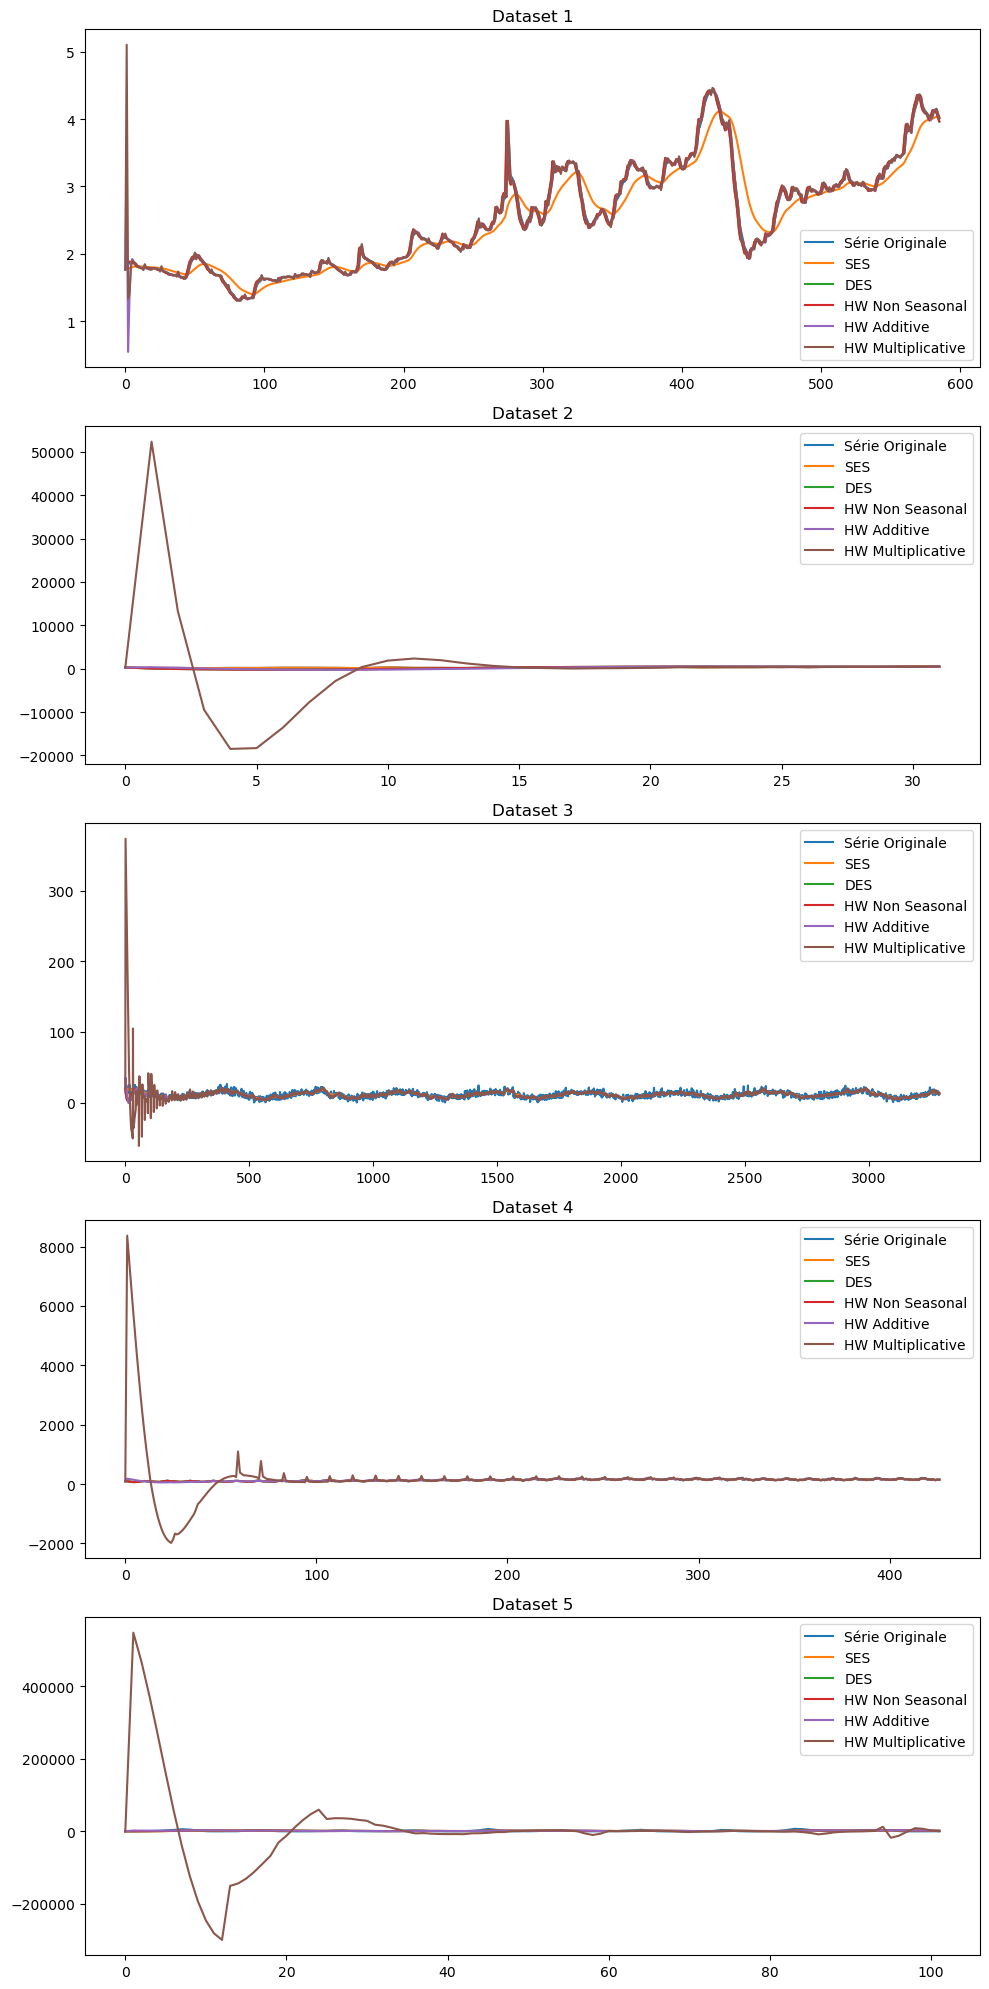

In [14]:
fig, axs = plt.subplots(len(datasets), 1, figsize=(10, 20))

for i, dataset in enumerate(datasets):
    train_size = int(len(dataset) * 0.9)
    train, test = dataset[:train_size], dataset[train_size:]

    # Récupération des meilleurs paramètres depuis train_results
    best_ses_alpha = train_results.loc[train_results['Dataset'] == dataset_names[i], 'Best Params'].values[0]
    best_des_params = train_results.loc[train_results['Dataset'] == dataset_names[i], 'Best Params'].values[1]
    best_hw_params = train_results.loc[train_results['Dataset'] == dataset_names[i], 'Best Params'].values[2]
    best_hw_add_params = train_results.loc[train_results['Dataset'] == dataset_names[i], 'Best Params'].values[3]
    best_hw_mul_params = train_results.loc[train_results['Dataset'] == dataset_names[i], 'Best Params'].values[4]

    # Vérification et conversion si nécessaire de best_ses_alpha
    if isinstance(best_ses_alpha, (list, tuple)):
        best_ses_alpha = best_ses_alpha[0]

    # Utilisation des meilleurs paramètres pour prédire sur les données d'entraînement
    ses_forecast = simple_exponential_smoothing(train.iloc[:, 1], best_ses_alpha)
    des_forecast = double_exponential_smoothing(train.iloc[:, 1], *best_des_params)
    hw_forecast = holt_winters_non_seasonal(train.iloc[:, 1], *best_hw_params)
    hw_add_forecast = holt_winters_additive(train.iloc[:, 1], *best_hw_add_params, season_length=12)
    hw_mul_forecast = holt_winters_multiplicative(train.iloc[:, 1], *best_hw_mul_params, season_length=12)

    # Tracer les prévisions et la série originale
    axs[i].plot(train.index, train.iloc[:, 1], label='Série Originale')
    axs[i].plot(train.index, ses_forecast, label='SES')
    axs[i].plot(train.index, des_forecast, label='DES')
    axs[i].plot(train.index, hw_forecast, label='HW Non Seasonal')
    axs[i].plot(train.index, hw_add_forecast, label='HW Additive')
    axs[i].plot(train.index, hw_mul_forecast, label='HW Multiplicative')
    axs[i].set_title(dataset_names[i])
    axs[i].legend()

plt.tight_layout()
plt.show()
